Link: https://amaarora.github.io/2020/09/13/unet.html, https://blog.csdn.net/weixin_41424926/article/details/103105801, https://blog.csdn.net/u012426298/article/details/82083149

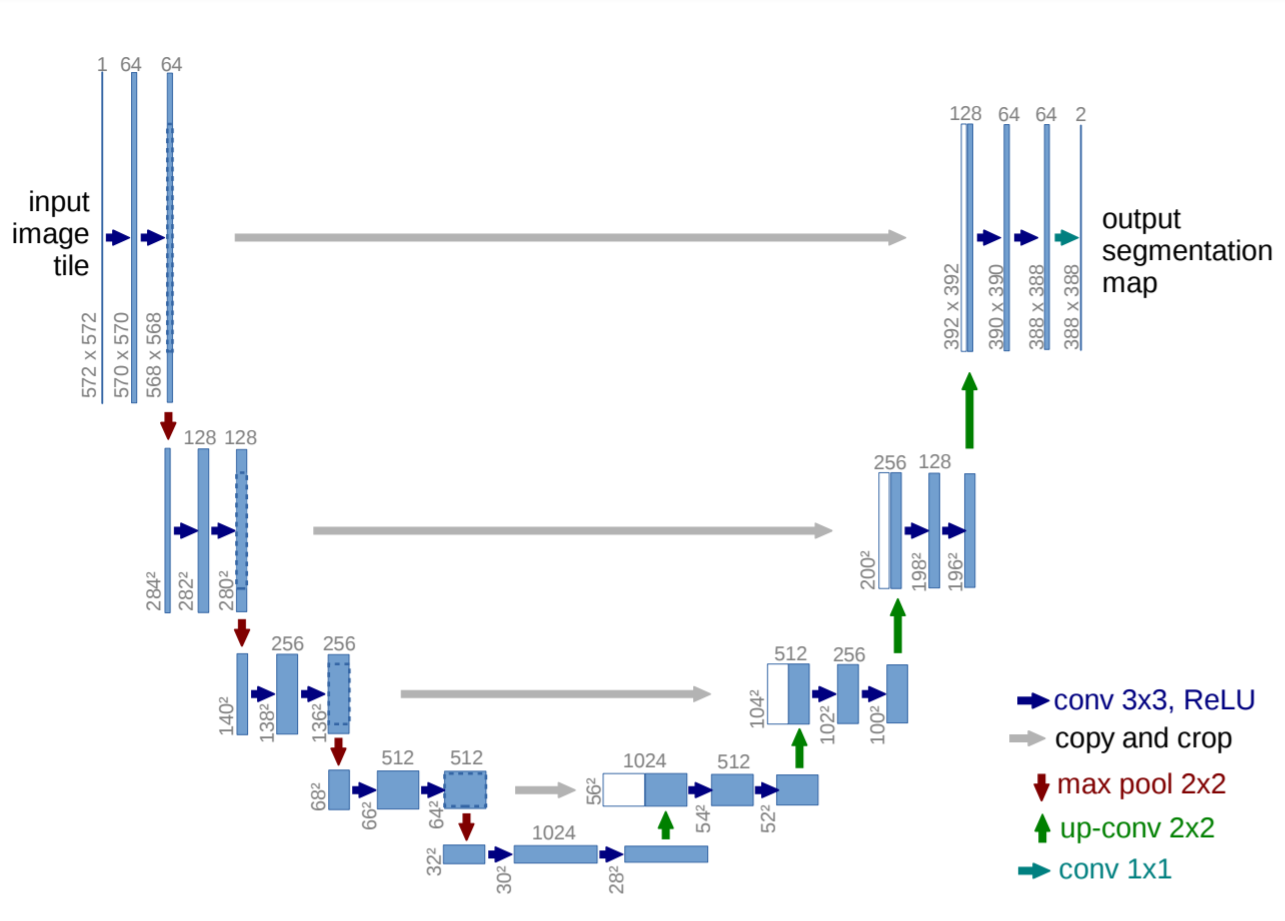

In [5]:
import torch
from torch import nn

# 每一段都是两个卷积，每个卷积之后都有一个激活层
# 第一个卷积将通道数翻倍，第二个卷积不翻倍
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [6]:
encodeBlock = Block(1, 64)
# batch size, channels, height, width
x = torch.rand(1, 1, 572, 572)
encodeBlock(x).shape

torch.Size([1, 64, 568, 568])

可以看到，经过 `1*572*572` 的输入经过卷积之后就变成了 `64*568*568` 的输出，和 UNet 的网络结构的第一段卷积正好符合。

很重要的两个概念就是 `contractive path` 和 `expansive path`，很多地方也分别称为 `Encoder` 和 `Decoder`，听起来非常高大上，其实就是左边的逐渐增加通道减小尺寸，和右边的减少通道增加尺寸的两个过程。

In [10]:
class Encoder(nn.Module):
    def __init__(self, channels=(3, 64, 128, 256, 512, 1024)):
        """
        channels: 表示每个 Block 输入、输出的通道数
        我们这里用的输入数据是 3 通道的，和原始论文 1 个通道有所区别
        """
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels) - 1)])
        # 最大池化层用来降低尺寸，没有训练参数所以可以共用
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            # 保存备用，对应图中灰色的横线
            ftrs.append(x)
            # Each block is followed by a 2*2 max pooling operation with stride 2 for downsampling
            x = self.pool(x)
        return ftrs


In [11]:
encoder = Encoder()
# input image
x = torch.rand(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs:
    print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [20]:
import torchvision

class Decoder(nn.Module):
    def __init__(self, channels=(1024, 512, 256, 128, 64)):
        """
        channels: 还是表示每个 Block 输入、输出的通道数
        """
        super().__init__()
        # nn.Sequential 和 nn.ModuleList 的区别，在于 nn.Sequential 相邻两层之间输入输出是必须匹配的
        # https://zhuanlan.zhihu.com/p/64990232
        
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels) - 1)])
        self.dec_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels) - 1)])
        
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            # 对上层的结果反卷积一下
            x = self.upconvs[i](x)
            # 从 encoder 的输出里面拿到对应层的输出来，concat 一下
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [18]:
print(len(ftrs))
# 翻转，然后取第 2 个及以后的结果
print(len(ftrs[::-1][1:]))
ftrs_for_decoder = ftrs[::-1][1:]

5
4


In [21]:
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs_for_decoder).shape

torch.Size([1, 64, 388, 388])

In [24]:
from torch.nn import functional as F
class UNet(nn.Module):
    def __init__(self, encode_channels=(3, 64, 128, 256, 512, 1024), decode_channels=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder = Encoder(encode_channels)
        self.decoder = Decoder(decode_channels)
        # out_channels 就是类别数量，每个 channel 表示一个分割结果
        # kernel size 就是 1，保持维度不变
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        self.retain_dim = retain_dim
        self.out_sz = out_sz
    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [25]:
unet = UNet()
x = torch.rand(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])